In [1]:
from rtlsdr import RtlSdr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import csv
import time
import math

/home/azureglades/Coding/pythong/meteor-detection-dhruva/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
sdr = RtlSdr()
sdr.sample_rate = 2.4e6 # Hz
sdr.center_freq = 92.7e6   # Hz
sdr.freq_correction = 60  # PPM
sdr.gain = 'auto'

print(len(sdr.read_samples(1024)))
sdr.close()

TypeError: BaseRtlSdr.__init__() got an unexpected keyword argument 'hostname'

Detached kernel driver
Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]
49.6


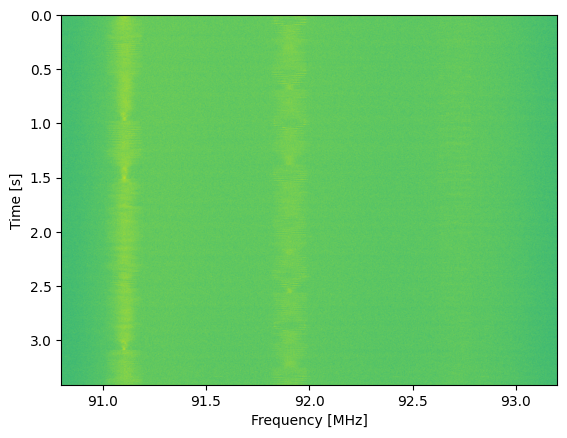

Reattached kernel driver


In [2]:

sdr = RtlSdr()
sdr.sample_rate = 2.4e6 # Hz
sdr.center_freq = 92.0e6   # Hz
sdr.freq_correction = 60  # PPM
print(sdr.valid_gains_db)
sdr.gain = 49.6
print(sdr.gain)
fft_size = 1024
num_rows = 8000
#x = sdr.read_samples(2048*2400) # set how mnay samples to listen to
x = sdr.read_samples(fft_size*num_rows) # get all the samples we need for the spectrogram
spectrogram = np.zeros((num_rows, fft_size))
for i in range(num_rows):
    spectrogram[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x[i*fft_size:(i+1)*fft_size])))**2)
extent = [(sdr.center_freq + sdr.sample_rate/-2)/1e6,
            (sdr.center_freq + sdr.sample_rate/2)/1e6,
            len(x)/sdr.sample_rate, 0]
plt.imshow(spectrogram, aspect='auto', extent=extent)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()
sdr.close()


In [4]:
spect_df = pd.DataFrame(spectrogram)
spect_df.to_csv("spectrogram_nometeor.csv")
#spect_df = pd.read_csv("spectrogram1.csv")

In [5]:
interval_width = 5
num_intervals = int(num_rows/interval_width)
mean_vals = np.zeros((num_intervals, 1))

for i in range(0,num_rows,interval_width):
    mean_vals[int(i/interval_width)] = spect_df.iloc[i:i+interval_width].values.mean()


Text(0, 0.5, 'energy (in dB)')

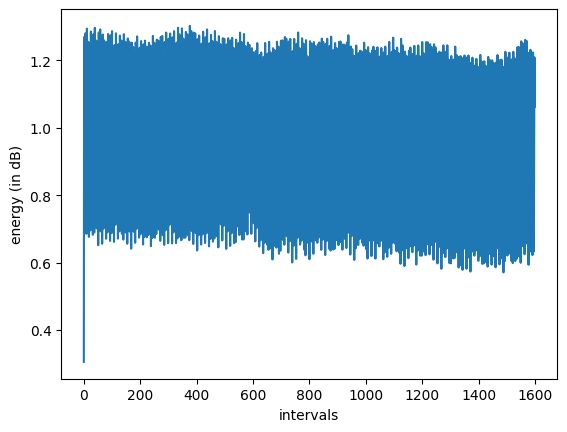

In [6]:
noise_floor = np.sqrt(np.mean(mean_vals**2))
normalized_mean_vals = mean_vals/noise_floor
plt.plot(range(0,num_intervals),normalized_mean_vals)
normalized_mean_vals.max() - normalized_mean_vals.min()
plt.xlabel("intervals")
plt.ylabel("energy (in dB)")

In [7]:
d_mean_vals = np.zeros((num_intervals,1))
for i in range(0,num_intervals-1):
    d_mean_vals[i] = (normalized_mean_vals[i+1] - normalized_mean_vals[i])/interval_width

np.float64(9.454108148734073e-05)

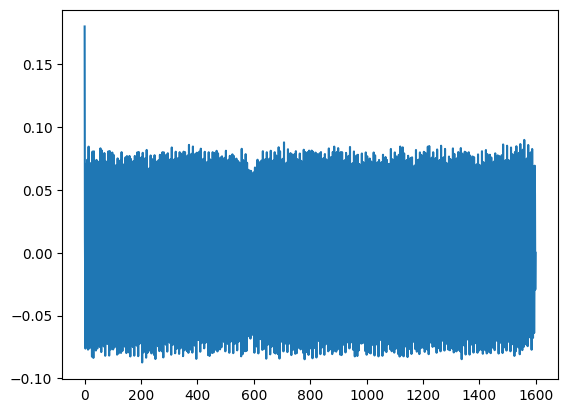

In [8]:
plt.plot(range(0,num_intervals),d_mean_vals)
mean_change = d_mean_vals.mean()
mean_change

<StemContainer object of 3 artists>

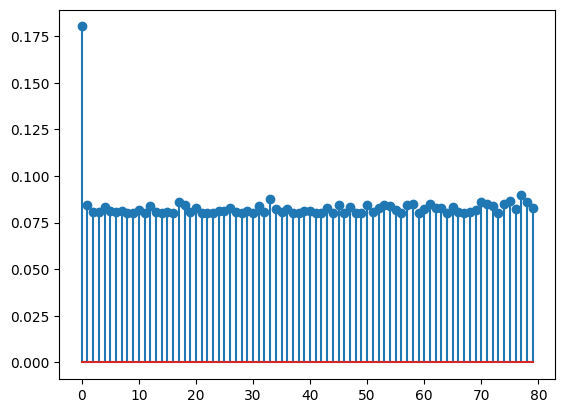

In [9]:
mean_change = np.percentile(d_mean_vals, 95)
above_threshold = d_mean_vals[d_mean_vals > mean_change]

plt.stem(range(0,len(above_threshold)),above_threshold)

In [23]:
threshold = np.percentile(d_mean_vals, 75)  # 75th percentile (adjust as needed)
peaks_mask = d_mean_vals > threshold  # Boolean mask for peaks